In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
import optuna
from optuna.trial import TrialState

from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data

In [2]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv")
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv")
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv")

In [3]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

### Establishing baseline brier score for default hyperparameters

In [4]:
RANDOM_STATE = 42
model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
model.fit(X1_train, y1_train)
y_proba = model.predict_proba(X1_test)[:, 1]
brier1 = brier_score_loss(y1_test, y_proba)
model.fit(X2_train, y2_train)
y2_proba = model.predict_proba(X2_test)[:, 1]
brier2 = brier_score_loss(y2_test, y2_proba)
model.fit(X3_train, y3_train)
y3_proba = model.predict_proba(X3_test)[:, 1]
brier3 = brier_score_loss(y3_test, y3_proba)
model.fit(X4_train, y4_train)
y4_proba = model.predict_proba(X4_test)[:, 1]
brier4 = brier_score_loss(y4_test, y4_proba)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of c

[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 8929, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473849 -> initscore=-0.104699
[LightGBM] [Info] Start training from score -0.104699


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklea

[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1583, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401137 -> initscore=-0.400730
[LightGBM] [Info] Start training from score -0.400730
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Inf

In [5]:
print(brier1)
print(brier2)
print(brier3)
print(brier4)

0.1835232471728478
0.2018081787955161
0.0982194936261805
0.178996854771902


### Random search optimization
https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html?utm_source=chatgpt.com

In [6]:
param_grid = {
    'num_leaves': randint(15, 128),
    'max_depth': randint(3, 15),  
    'learning_rate': loguniform(0.01, 0.3),
    'n_estimators': randint(100, 1500),
    'min_data_in_leaf': randint(10, 200),
    'lambda_l1': loguniform(1e-4, 10),  
    'lambda_l2': loguniform(1e-4, 10)
}

In [7]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10           
TOL = 0.001 
CV = 5

In [8]:
iters = np.arange(1, N_ITER + 1)

In [9]:
model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs = 1)

In [10]:
rnd = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=N_ITER,
    scoring=SCORER,
    verbose=0,
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)

In [11]:
def train_tuned(params, X_train, y_train, X_test, y_test):
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    score = brier_score_loss(y_test, y_proba)
    return score

#### Bank data

In [12]:
rnd.fit(X1_train, y1_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wi

,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001ECAA222850>, 'lambda_l2': <scipy.stats....001ECAA222990>, 'learning_rate': <scipy.stats....001ECAA25D2B0>, 'max_depth': <scipy.stats....001ECAA222490>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [22]:
rnd.best_params_

{'lambda_l1': np.float64(0.0010799951355893044),
 'lambda_l2': np.float64(0.0023431799179763242),
 'learning_rate': np.float64(0.020747900173109644),
 'max_depth': 4,
 'min_data_in_leaf': 44,
 'n_estimators': 826,
 'num_leaves': 95}

In [23]:
best_so_far[-1]

np.float64(0.18386437309700304)

### Criterium of stabilization - in 10 steps in a row there is no improvement in brier score more than 1e-3

In [13]:
WINDOW_SIZE = 10 
ABS_TOL = 0.001   

In [14]:
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

In [26]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [27]:
print(stabilized_at, stabilized_value)

2 0.1856140031909646


In [11]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, default):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title('Brier per Random Search iteration and best-so-far')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

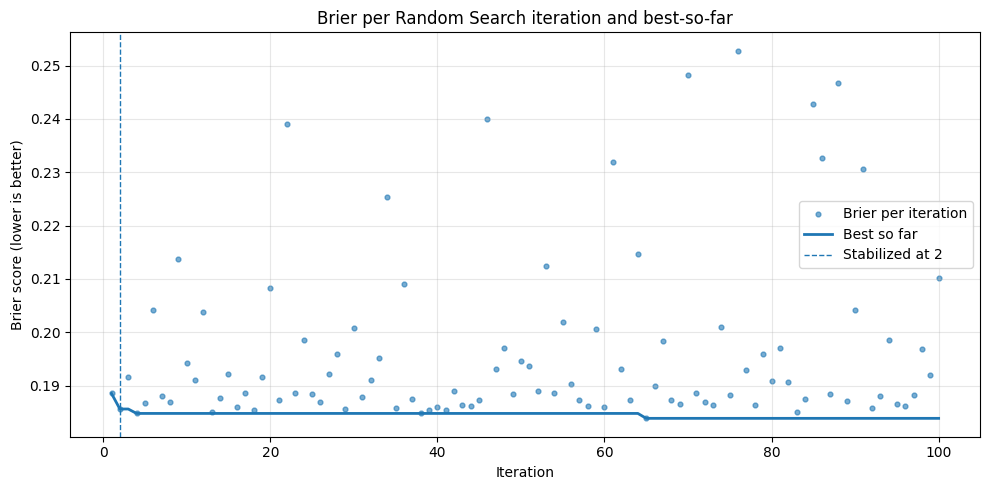

In [29]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier1)

##### Benchmark on test data with those hyperparams

In [32]:
best_params = rnd.best_params_
brier_adjusted1 = train_tuned(best_params, X1_train, y1_train, X1_test, y1_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=0.0010799951355893044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010799951355893044
[LightGBM] [Warning] lambda_l2 is set=0.0023431799179763242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023431799179763242
[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wi

In [33]:
print(brier_adjusted1, brier1)

0.18111966687301606 0.1835232471728478


#### Gym data

In [34]:
rnd.fit(X2_train, y2_train)

[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001A51E59B890>, 'lambda_l2': <scipy.stats....001A51E59BC50>, 'learning_rate': <scipy.stats....001A51E6023C0>, 'max_depth': <scipy.stats....001A51E59BB10>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [35]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [36]:
rnd.best_params_

{'lambda_l1': np.float64(0.00922459366331435),
 'lambda_l2': np.float64(1.399010917215618),
 'learning_rate': np.float64(0.06927911541220201),
 'max_depth': 3,
 'min_data_in_leaf': 107,
 'n_estimators': 204,
 'num_leaves': 113}

In [37]:
best_so_far[-1]

np.float64(0.14684339342706773)

In [38]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [39]:
print(stabilized_at, stabilized_value)

7 0.1489718188992759


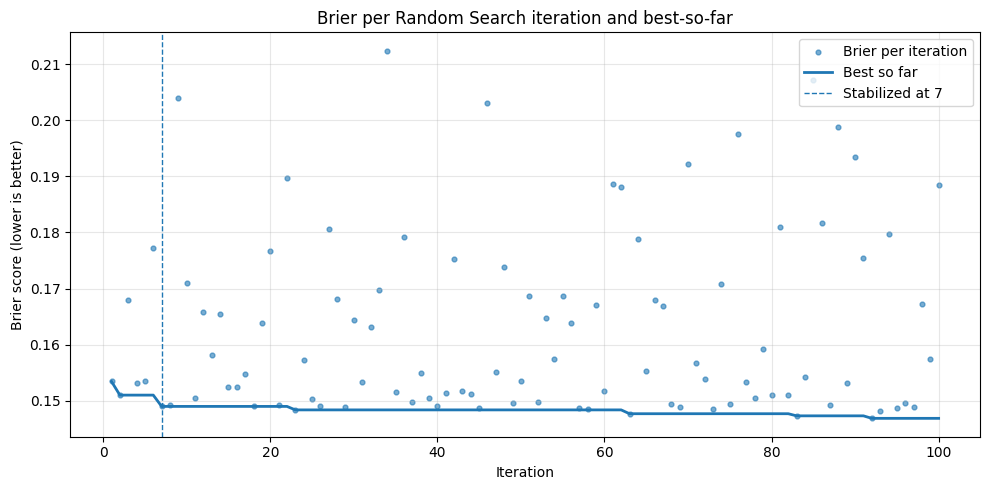

In [40]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier2)

In [41]:
best_params = rnd.best_params_
brier_adjusted2 = train_tuned(best_params, X2_train, y2_train, X2_test, y2_test)

[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.00922459366331435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00922459366331435
[LightGBM] [Warning] lambda_l2 is set=1.399010917215618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399010917215618
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [42]:
print(brier_adjusted2, brier2)

0.17634326427209 0.2018081787955161


#### Heart disease data

In [43]:
rnd.fit(X3_train, y3_train)

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001A51E59B890>, 'lambda_l2': <scipy.stats....001A51E59BC50>, 'learning_rate': <scipy.stats....001A51E6023C0>, 'max_depth': <scipy.stats....001A51E59BB10>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [44]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [45]:
rnd.best_params_

{'lambda_l1': np.float64(0.024046589187280348),
 'lambda_l2': np.float64(1.435018335977515),
 'learning_rate': np.float64(0.02848552988592319),
 'max_depth': 3,
 'min_data_in_leaf': 63,
 'n_estimators': 335,
 'num_leaves': 19}

In [46]:
best_so_far[-1]

np.float64(0.1230000359906959)

In [47]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [48]:
print(stabilized_at, stabilized_value)

3 0.12410485810542722


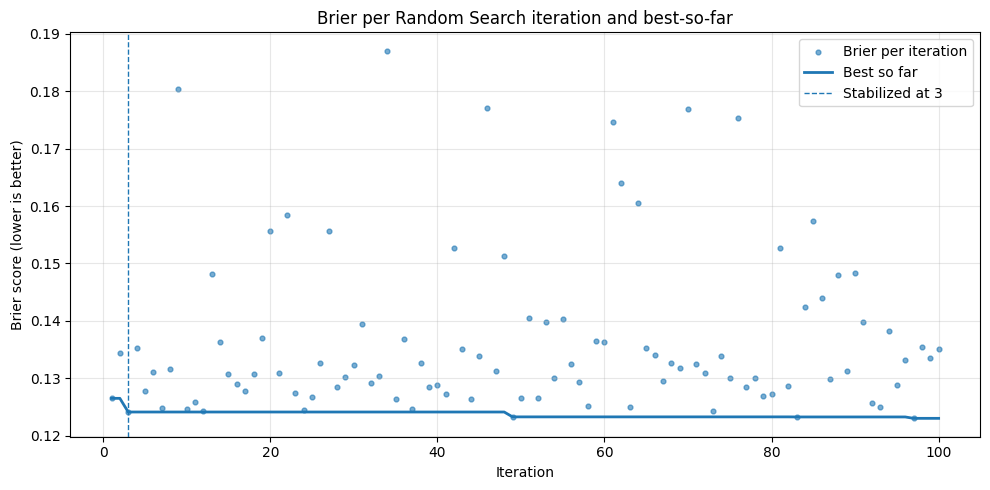

In [49]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier3)

In [50]:
best_params = rnd.best_params_
brier_adjusted3 = train_tuned(best_params, X3_train, y3_train, X3_test, y3_test)

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=0.024046589187280348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024046589187280348
[LightGBM] [Warning] lambda_l2 is set=1.435018335977515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435018335977515
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [51]:
print(brier_adjusted3, brier3)

0.09262259701874374 0.0982194936261805


#### Titanic data

In [52]:
rnd.fit(X4_train, y4_train)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Info] Number of positive: 271, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'lambda_l1': <scipy.stats....001A51E59B890>, 'lambda_l2': <scipy.stats....001A51E59BC50>, 'learning_rate': <scipy.stats....001A51E6023C0>, 'max_depth': <scipy.stats....001A51E59BB10>, ...}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [53]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [54]:
rnd.best_params_

{'lambda_l1': np.float64(1.3783040076490758),
 'lambda_l2': np.float64(0.002278843910062451),
 'learning_rate': np.float64(0.2665593954919876),
 'max_depth': 9,
 'min_data_in_leaf': 15,
 'n_estimators': 976,
 'num_leaves': 110}

In [55]:
best_so_far[-1]

np.float64(0.1068854416989623)

In [56]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [57]:
print(stabilized_at, stabilized_value)

4 0.11104287081018767


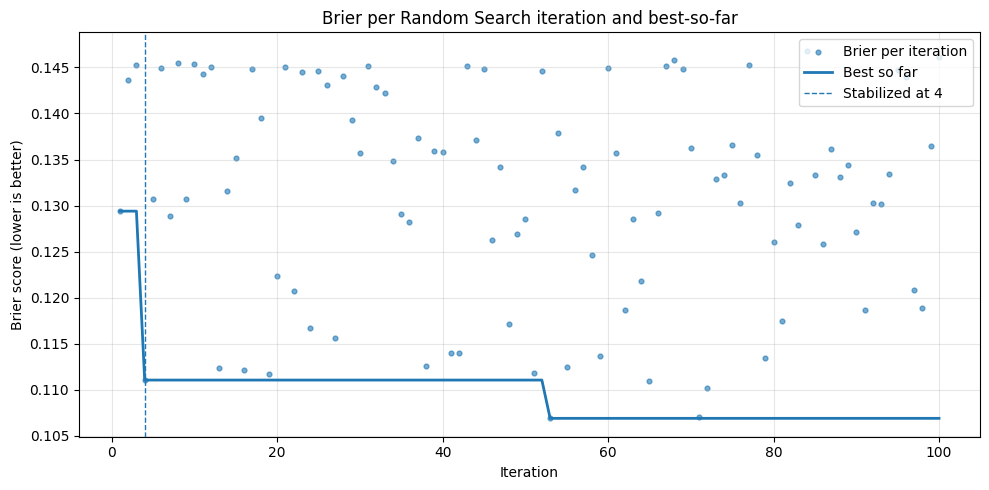

In [58]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier4)

In [59]:
best_params = rnd.best_params_
brier_adjusted4 = train_tuned(best_params, X4_train, y4_train, X4_test, y4_test)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.3783040076490758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3783040076490758
[LightGBM] [Warning] lambda_l2 is set=0.002278843910062451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002278843910062451
[LightGBM] [Info] Number of positive: 271, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [60]:
print(brier_adjusted4, brier4)

0.15942538000177728 0.178996854771902


### Bayesian optimization - optuna with pruning

In [12]:
def bayes_optimize(X_loc, y_arr, n_trials=N_ITER, cv=CV, random_state=RANDOM_STATE, n_jobs_model=1, pruner_n_startup_trials=10):
    y_arr = y_arr.iloc[:, 0].to_numpy().ravel()
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    sampler = optuna.samplers.TPESampler(seed=random_state)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=pruner_n_startup_trials, n_warmup_steps=0, interval_steps=1)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 15, 127),          
            'max_depth': trial.suggest_int('max_depth', 3, 14),      
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1499),    
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 199),
            'reg_alpha': trial.suggest_float('lambda_l1', 1e-4, 10.0, log=True), 
            'reg_lambda': trial.suggest_float('lambda_l2', 1e-4, 10.0, log=True), 
        }

        model = lgb.LGBMClassifier(**params, objective='binary',
                                   n_jobs=n_jobs_model, random_state=random_state, verbosity=-1)

        neg_briers = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_loc, y_arr)):
            X_tr = X_loc.iloc[train_idx] 
            X_val = X_loc.iloc[val_idx]
            y_tr = y_arr[train_idx]
            y_val = y_arr[val_idx]

            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='binary_logloss'
            )

            probs = model.predict_proba(X_val)[:, 1]
            neg_brier = -brier_score_loss(y_val, probs) 
            neg_briers.append(neg_brier)

            mean_neg_so_far = float(np.mean(neg_briers))
            trial.report(mean_neg_so_far, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        mean_neg = float(np.mean(neg_briers))
        return mean_neg
    
    study.optimize(objective, n_trials=n_trials)

    trials = study.trials
    records = []
    neg_scores = []  
    for t in trials:
        params = t.params
        if t.state == TrialState.PRUNED or t.value is None:
            mean_brier = np.nan
        else:
            mean_brier = float(t.value)
        neg_scores.append(mean_brier)
        records.append({'trial_number': t.number, 'params': params, 'mean_test_score': mean_brier, 'state': str(t.state)})

    mean_test_scores = np.array(neg_scores, dtype=float)    
    brier_per_iter = -mean_test_scores     

    best_so_far = []
    current_best = np.inf
    for v in brier_per_iter:
        if np.isnan(v):
            best_so_far.append(current_best if current_best != np.inf else np.nan)
        else:
            if v < current_best:
                current_best = v
            best_so_far.append(current_best)
    best_so_far = np.array(best_so_far, dtype=float)

    completed = [t for t in trials if t.state == TrialState.COMPLETE and t.value is not None]
    best_trial = max(completed, key=lambda tr: tr.value)
    best_params = best_trial.params
    best_brier = float(best_trial.value)

    return {
        'brier_per_iter': brier_per_iter,
        'best_so_far': best_so_far,
        'best_params': best_params,
        'best_brier': best_brier
    }

##### Bank data

In [ ]:
result = bayes_optimize(X1_train, y1_train)

[I 2025-10-19 22:12:58,682] A new study created in memory with name: no-name-78c7cfbf-d1b4-4eaf-89cb-4213cb3d2b45
[I 2025-10-19 22:13:05,172] Trial 0 finished with value: -0.2319173101089203 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.2319173101089203.
[I 2025-10-19 22:13:05,833] Trial 1 finished with value: -0.18751772330482236 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.18751772330482236.
[I 2025-10-19 22:13:08,637] Trial 2 finished with value: -0.18529371716647913 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'la

In [105]:
brier_per_iter = result["brier_per_iter"]
best_so_far = result["best_so_far"]

In [106]:
result["best_params"]

{'num_leaves': 48,
 'max_depth': 3,
 'learning_rate': 0.05435540423360091,
 'n_estimators': 530,
 'min_child_samples': 17,
 'lambda_l1': 0.002952940475566768,
 'lambda_l2': 0.008827094934083417}

In [107]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [108]:
print(stabilized_at, stabilized_value)

5 0.18317651939565222


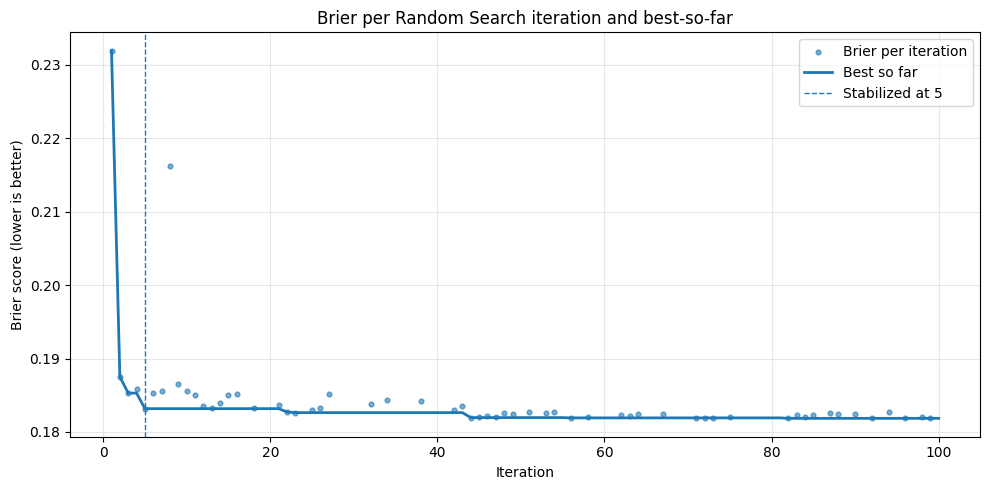

In [109]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier1)

In [110]:
best_params = result["best_params"]
brier_adjusted1_bayes = train_tuned(best_params, X1_train, y1_train, X1_test, y1_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
print(brier_adjusted1, brier_adjusted1_bayes, brier1)

0.18122801197098 0.1835232471728478


##### Gym data

In [113]:
result = bayes_optimize(X2_train, y2_train)

[I 2025-10-19 22:17:47,540] A new study created in memory with name: no-name-b11d22c6-8542-4c3d-b204-f13b59efc11d
[I 2025-10-19 22:17:49,993] Trial 0 finished with value: -0.2060086962707781 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.2060086962707781.
[I 2025-10-19 22:17:50,127] Trial 1 finished with value: -0.14688722719377856 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.14688722719377856.
[I 2025-10-19 22:17:51,099] Trial 2 finished with value: -0.15816024005394969 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'la

In [114]:
brier_per_iter = result["brier_per_iter"]
best_so_far = result["best_so_far"]
result["best_params"]

{'num_leaves': 121,
 'max_depth': 11,
 'learning_rate': 0.015085930199236954,
 'n_estimators': 1238,
 'min_child_samples': 195,
 'lambda_l1': 0.6454514615582414,
 'lambda_l2': 4.947618936915183}

In [115]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [116]:
print(stabilized_at, stabilized_value)

2 0.14688722719377856


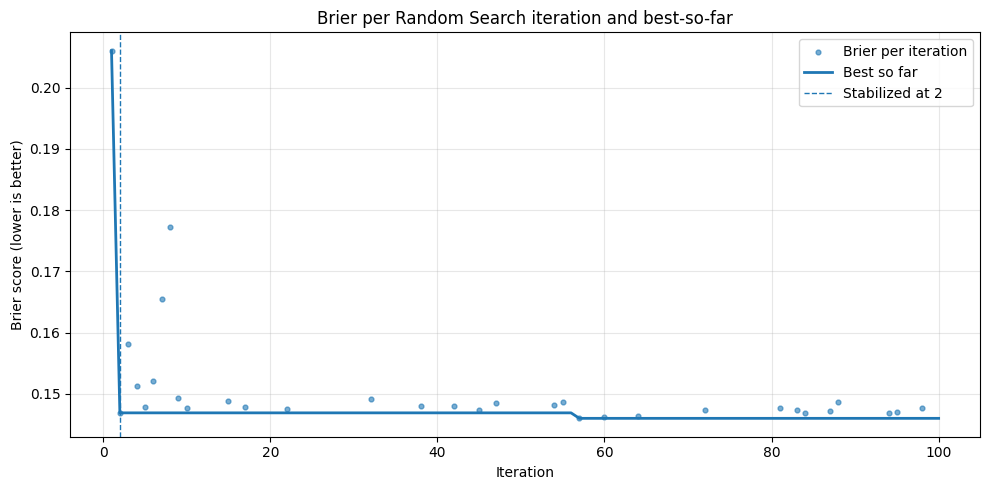

In [117]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier2)

In [118]:
best_params = result["best_params"]
brier_adjusted2_bayes = train_tuned(best_params, X2_train, y2_train, X2_test, y2_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [120]:
print(brier_adjusted2, brier_adjusted2_bayes, brier2)

0.17634326427209 0.17641367844845726 0.2018081787955161


##### Heart disease data

In [121]:
result = bayes_optimize(X3_train, y3_train)

[I 2025-10-19 22:21:39,778] A new study created in memory with name: no-name-1851f8aa-5c8e-469e-b67a-f1e8ccecf895
[I 2025-10-19 22:21:40,689] Trial 0 finished with value: -0.17586775595353163 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.17586775595353163.
[I 2025-10-19 22:21:40,759] Trial 1 finished with value: -0.1310773887626961 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.1310773887626961.
[I 2025-10-19 22:21:41,196] Trial 2 finished with value: -0.12704920544238346 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'la

In [122]:
brier_per_iter = result["brier_per_iter"]
best_so_far = result["best_so_far"]
result["best_params"]

{'num_leaves': 111,
 'max_depth': 3,
 'learning_rate': 0.1393294953681854,
 'n_estimators': 184,
 'min_child_samples': 14,
 'lambda_l1': 3.8202799180166545,
 'lambda_l2': 0.020159194967265724}

In [123]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [124]:
print(stabilized_at, stabilized_value)

5 0.12163040189188941


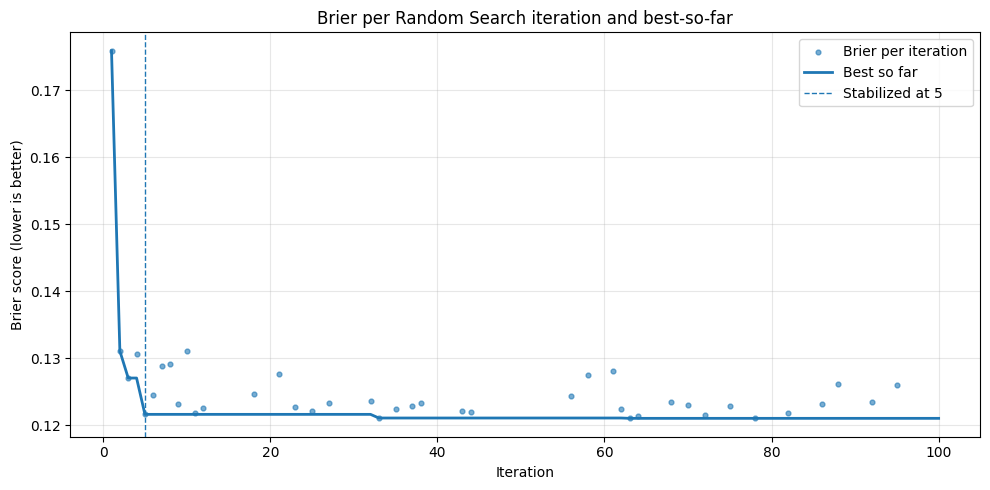

In [125]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier3)

In [128]:
best_params = result["best_params"]
brier_adjusted3_bayes = train_tuned(best_params, X3_train, y3_train, X3_test, y3_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [129]:
print(brier_adjusted3, brier_adjusted3_bayes, brier3)

0.09262259701874374 0.09400881135862903 0.0982194936261805


##### Titanic data

In [16]:
result = bayes_optimize(X4_train, y4_train)

[I 2025-10-19 22:38:09,720] A new study created in memory with name: no-name-7bb762bf-0641-45ad-a761-5a38cdf022df
[I 2025-10-19 22:38:10,641] Trial 0 finished with value: -0.1542412412999048 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.1542412412999048.
[I 2025-10-19 22:38:10,705] Trial 1 finished with value: -0.14349168327155956 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.14349168327155956.
[I 2025-10-19 22:38:11,102] Trial 2 finished with value: -0.12448348768738401 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'la

In [17]:
brier_per_iter = result["brier_per_iter"]
best_so_far = result["best_so_far"]
result["best_params"]

{'num_leaves': 71,
 'max_depth': 9,
 'learning_rate': 0.021733200861349226,
 'n_estimators': 190,
 'min_child_samples': 20,
 'lambda_l1': 0.6498966498082488,
 'lambda_l2': 0.19982074000815617}

In [18]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [19]:
print(stabilized_at, stabilized_value)

7 0.11639523621313272


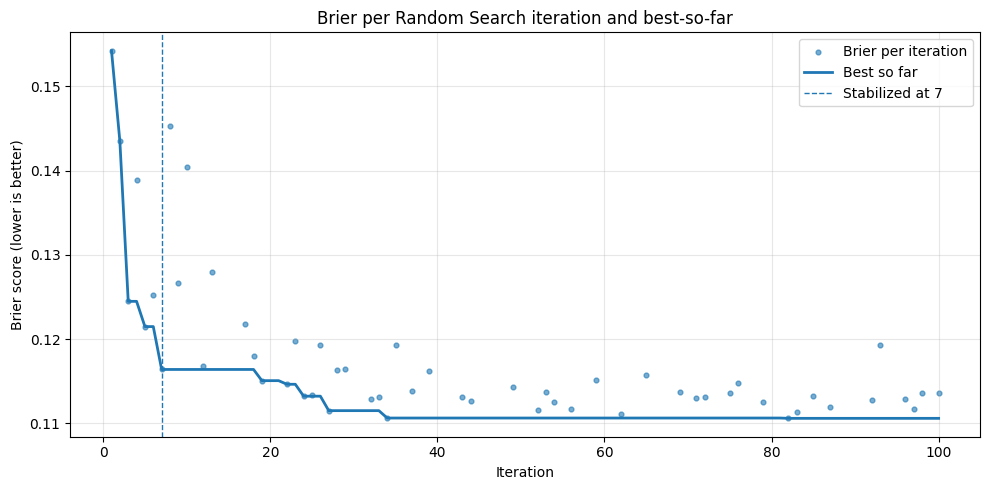

In [20]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier4)

In [134]:
best_params = result["best_params"]
brier_adjusted4_bayes = train_tuned(best_params, X4_train, y4_train, X4_test, y4_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [135]:
print(brier_adjusted4, brier_adjusted4_bayes, brier4)

0.15942538000177728 0.15707694668742653 0.178996854771902


### Tuning hyperparameters on subsets of original bank data dataset using Bayes optimization
Best score as average on Cross Validation sets out of 100 trials is saved with its params.

In [13]:
fractions = [0.25, 0.5, 0.75, 1.0]
results = []

In [14]:
def calculate_brier_for_subsets(X1, y1):   
    results = [] 
    for frac in fractions:
        if frac != 1:
            X_sub, _, y_sub, _ = train_test_split(
                X1, y1, train_size=frac, stratify=y1, random_state=RANDOM_STATE
            )
        else:
            X_sub = X1
            y_sub = y1

        X_train, X_test, y_train, y_test = train_test_split(
            X_sub, y_sub, train_size=0.8, stratify=y_sub, random_state=RANDOM_STATE
        )

        res = bayes_optimize(
            X_train, y_train,
            random_state=RANDOM_STATE,
            n_jobs_model=1,
            pruner_n_startup_trials=10
        )

        best_params = res.get('best_params')
        best_brier_cv = res.get('best_brier')

        final_model = lgb.LGBMClassifier(
            **{**best_params, 'n_jobs': 1, 'random_state': RANDOM_STATE}
        )
        final_model.fit(X_train, y_train)

        probs_test = final_model.predict_proba(X_test)[:, 1]
        brier_test = brier_score_loss(y_test, probs_test)

        print(f"Brier (CV, tuning): {best_brier_cv:.5f} | Brier (test): {brier_test:.5f}")

        results.append({
            'frac': frac,
            'best_params': best_params,
            'brier_cv': - best_brier_cv,
            'brier_test': brier_test
        })

    results_df = pd.DataFrame(results)
    return results_df


In [15]:
results = calculate_brier_for_subsets(X1, y1)

[I 2025-10-22 19:38:26,023] A new study created in memory with name: no-name-e208d73e-df6b-4066-a220-14588a58fc89
[I 2025-10-22 19:38:28,765] Trial 0 finished with value: -0.2806569978130541 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.2806569978130541.
[I 2025-10-22 19:38:28,940] Trial 1 finished with value: -0.20899044030408356 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.20899044030408356.
[I 2025-10-22 19:38:29,936] Trial 2 finished with value: -0.20325644289342987 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'la

Brier (CV, tuning): -0.19594 | Brier (test): 0.19960


[I 2025-10-22 19:39:02,399] Trial 0 finished with value: -0.2523877694220078 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.2523877694220078.
[I 2025-10-22 19:39:02,751] Trial 1 finished with value: -0.19143829184830133 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.19143829184830133.
[I 2025-10-22 19:39:04,602] Trial 2 finished with value: -0.19154974614273762 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'lambda_l1': 0.0028585493941961923, 'lambda_l2': 0.11462107403425033}. Best is trial 1 with value: -0.191438291848301

Brier (CV, tuning): -0.18402 | Brier (test): 0.19048


[I 2025-10-22 19:40:00,556] Trial 0 finished with value: -0.24537590501917803 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.24537590501917803.
[I 2025-10-22 19:40:01,748] Trial 1 finished with value: -0.1904389887068489 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.1904389887068489.
[I 2025-10-22 19:40:06,090] Trial 2 finished with value: -0.18534001877400194 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'lambda_l1': 0.0028585493941961923, 'lambda_l2': 0.11462107403425033}. Best is trial 2 with value: -0.185340018774001

Brier (CV, tuning): -0.18131 | Brier (test): 0.18802


[I 2025-10-22 19:42:25,336] Trial 0 finished with value: -0.2319173101089203 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.1205712628744377, 'n_estimators': 938, 'min_child_samples': 39, 'lambda_l1': 0.000602521573620386, 'lambda_l2': 0.00019517224641449495}. Best is trial 0 with value: -0.2319173101089203.
[I 2025-10-22 19:42:26,016] Trial 1 finished with value: -0.18751772330482236 and parameters: {'num_leaves': 112, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'n_estimators': 128, 'min_child_samples': 194, 'lambda_l1': 1.452824663751602, 'lambda_l2': 0.0011526449540315614}. Best is trial 1 with value: -0.18751772330482236.
[I 2025-10-22 19:42:28,860] Trial 2 finished with value: -0.18529371716647913 and parameters: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'n_estimators': 834, 'min_child_samples': 92, 'lambda_l1': 0.0028585493941961923, 'lambda_l2': 0.11462107403425033}. Best is trial 2 with value: -0.185293717166479

Brier (CV, tuning): -0.18186 | Brier (test): 0.18123


In [26]:
results

,frac,best_params,brier_cv,brier_test
0,0.25,"{'num_leaves': 41, 'max_depth': 3, 'learning_r...",0.195943,0.199599
1,0.50,"{'num_leaves': 93, 'max_depth': 3, 'learning_r...",0.184016,0.190480
2,0.75,"{'num_leaves': 64, 'max_depth': 3, 'learning_r...",0.181311,0.188018
3,1.00,"{'num_leaves': 48, 'max_depth': 3, 'learning_r...",0.181857,0.181228


### Result to further analysis

In [ ]:
random = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': [0.18111966687301606, 0.17634326427209, 0.09262259701874374, 0.15942538000177728 ],
    'baseline_brier': [0.1835232471728478, 0.2018081787955161, 0.0982194936261805, 0.178996854771902],
    'best params': [{'lambda_l1': np.float64(0.0010799951355893044),
 'lambda_l2': np.float64(0.0023431799179763242),
 'learning_rate': np.float64(0.020747900173109644),
 'max_depth': 4,
 'min_data_in_leaf': 44,
 'n_estimators': 826,
 'num_leaves': 95}, {'lambda_l1': np.float64(0.00922459366331435),
 'lambda_l2': np.float64(1.399010917215618),
 'learning_rate': np.float64(0.06927911541220201),
 'max_depth': 3,
 'min_data_in_leaf': 107,
 'n_estimators': 204,
 'num_leaves': 113}, {'lambda_l1': np.float64(0.024046589187280348),
 'lambda_l2': np.float64(1.435018335977515),
 'learning_rate': np.float64(0.02848552988592319),
 'max_depth': 3,
 'min_data_in_leaf': 63,
 'n_estimators': 335,
 'num_leaves': 19}, {'lambda_l1': np.float64(1.3783040076490758),
 'lambda_l2': np.float64(0.002278843910062451),
 'learning_rate': np.float64(0.2665593954919876),
 'max_depth': 9,
 'min_data_in_leaf': 15,
 'n_estimators': 976,
 'num_leaves': 110}]
}


In [ ]:
bayes = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': [0.18122801197098, 0.17641367844845726, 0.09400881135862903, 0.15707694668742653 ],
    'baseline_brier': [0.1835232471728478, 0.2018081787955161, 0.0982194936261805, 0.178996854771902],
    'best_params': [{'num_leaves': 48,
 'max_depth': 3,
 'learning_rate': 0.05435540423360091,
 'n_estimators': 530,
 'min_child_samples': 17,
 'lambda_l1': 0.002952940475566768,
 'lambda_l2': 0.008827094934083417}, {'num_leaves': 121,
 'max_depth': 11,
 'learning_rate': 0.015085930199236954,
 'n_estimators': 1238,
 'min_child_samples': 195,
 'lambda_l1': 0.6454514615582414,
 'lambda_l2': 4.947618936915183}, {'num_leaves': 111,
 'max_depth': 3,
 'learning_rate': 0.1393294953681854,
 'n_estimators': 184,
 'min_child_samples': 14,
 'lambda_l1': 3.8202799180166545,
 'lambda_l2': 0.020159194967265724}, {'num_leaves': 71,
 'max_depth': 9,
 'learning_rate': 0.021733200861349226,
 'n_estimators': 190,
 'min_child_samples': 20,
 'lambda_l1': 0.6498966498082488,
 'lambda_l2': 0.19982074000815617}] 
}



In [25]:
subsets = {
    'frac': [0.25, 0.50, 0.75, 1.00],
    'brier_cv': [0.195943, 0.184016, 0.181311, 0.181857],
    'brier_test': [0.199599, 0.190480, 0.188018, 0.181228],
    'best_params': [
        {'num_leaves': 41,
 'max_depth': 3,
 'learning_rate': 0.06634535820075341,
 'n_estimators': 286,
 'min_child_samples': 47,
 'lambda_l1': 0.13695227494564602,
 'lambda_l2': 9.977382596095024},
        {'num_leaves': 93,
 'max_depth': 3,
 'learning_rate': 0.10846684240269427,
 'n_estimators': 184,
 'min_child_samples': 17,
 'lambda_l1': 0.2739006821035618,
 'lambda_l2': 6.73800098234884},
        {'num_leaves': 64,
 'max_depth': 3,
 'learning_rate': 0.060104947349619416,
 'n_estimators': 369,
 'min_child_samples': 28,
 'lambda_l1': 0.8904689770478909,
 'lambda_l2': 1.544358693177717},
        {'num_leaves': 48,
 'max_depth': 3,
 'learning_rate': 0.05435540423360091,
 'n_estimators': 530,
 'min_child_samples': 17,
 'lambda_l1': 0.002952940475566768,
 'lambda_l2': 0.008827094934083417}
    ]
}